## Modeling - Fraud Detection 

### Imports

In [1]:
# -----------------------------
# Imports & Setup
# -----------------------------
import sys
from pathlib import Path
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    roc_curve, RocCurveDisplay
)

import joblib

# -----------------------------
# Project Path Setup
# -----------------------------
project_root = Path.cwd().resolve().parent
sys.path.append(str(project_root))

# -----------------------------
# Custom Modules
# -----------------------------
from src.data.loader import FraudDataLoader
from src.modeling import ModelingPipeline
from src.utils.io_utils import save_dataframe

# -----------------------------
# Pandas & Seaborn Settings
# -----------------------------
pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid")

# -----------------------------
# Logging Setup
# -----------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("Modeling_Fraud")


### Load Feature Engineered Data

In [2]:
# -----------------------------
# Load Processed Data
# -----------------------------
fraud_loader = FraudDataLoader("../data/processed/fraud_data_with_features.csv")

fraud_df = fraud_loader.load()

logger.info(f"Fraud data shape: {fraud_df.shape}")
logger.info(f"Fraud data columns: {fraud_df.columns}")



2025-12-30 21:05:48,212 [INFO] Fraud data shape: (151112, 17)
2025-12-30 21:05:48,219 [INFO] Fraud data columns: Index(['purchase_time', 'user_id', 'signup_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'hour_of_day', 'day_of_week', 'time_since_signup',
       'transactions_per_user', 'transactions_last_24h'],
      dtype='object')


### Setup Modeling Pipeline

In [3]:
# -------------------------------
# Features
# -------------------------------
NUMERIC_FEATURES = [
    'purchase_value',
    'age',
    'hour_of_day',
    'day_of_week',
    'time_since_signup',
    'transactions_per_user',
    'transactions_last_24h'
]

CATEGORICAL_FEATURES = ['source', 'browser', 'sex', 'country']
TARGET = 'class'

pipeline = ModelingPipeline(
    df=fraud_df,
    numeric_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    target_col=TARGET,
    use_smote=True
)


### Prepare Data for Modeling - Split, Scale, Encode

In [4]:
X_train, X_test, y_train, y_test = pipeline.prepare_data()

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())

2025-12-30 21:05:48,240 [INFO] Step 1: Preparing data...
2025-12-30 21:05:48,596 [INFO] Training shape: (120889, 196), Test shape: (30223, 196)


Training set: 120,889 samples
Test set: 30,223 samples

Training class distribution:
class
0    109568
1     11321
Name: count, dtype: int64

Test class distribution:
class
0    27393
1     2830
Name: count, dtype: int64


2025-12-30 21:05:48,711 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-30 21:05:48,768 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-30 21:05:48,839 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-30 21:05:48,859 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


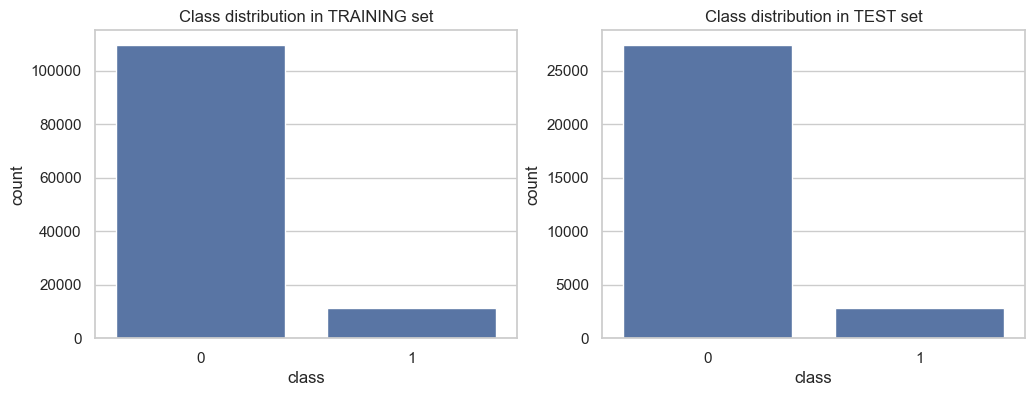

In [5]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Class distribution in TRAINING set")
plt.subplot(1,2,2)
sns.countplot(x=y_test)
plt.title("Class distribution in TEST set")
plt.show()

### Train Models - Logistic Regression

In [6]:
lr_model = pipeline.tune_and_train_logistic_regression()


2025-12-30 21:07:05,097 [INFO] Running Stratified 5-Fold CV...
2025-12-30 21:07:20,313 [INFO] Logistic Regression best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


### Evaluate Models - Logistic Regression

In [7]:
metrics = pipeline.evaluate(lr_model)
print("Metrics for Logistic Regression:")
for k,v in metrics.items():
    if k != "ConfusionMatrix":
        print(f"{k}: {v:.3f}")

Metrics for Logistic Regression:
AUC_PR: 0.438
F1: 0.275
Precision: 0.171
Recall: 0.699


### Classification Report - Logistic Regression

In [8]:
y_pred = lr_model.predict(X_test)  # X_test = preprocessed test set, not SMOTE
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)


              precision    recall  f1-score       support
0              0.954268  0.649765  0.773113  27393.000000
1              0.170858  0.698587  0.274564   2830.000000
accuracy       0.654336  0.654336  0.654336      0.654336
macro avg      0.562563  0.674176  0.523839  30223.000000
weighted avg   0.880911  0.654336  0.726430  30223.000000


### Confusion Matrix - Logistic Regression

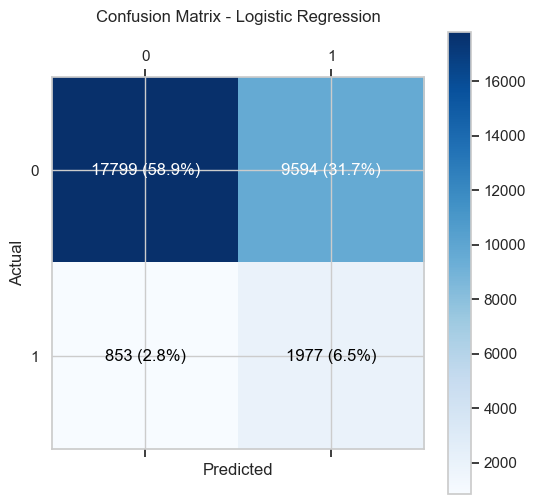

In [9]:


# Get predictions
y_pred = lr_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_sum = np.sum(cm)
cm_percent = cm / cm_sum * 100  # percentages

# Create labels with both count and percentage
labels = np.array([["{} ({:.1f}%)".format(value, percent) 
                    for value, percent in zip(row_val, row_pct)]
                   for row_val, row_pct in zip(cm, cm_percent)])

# Plot
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(cm, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression", pad=20)
plt.colorbar(cax)

# Show text inside cells with color contrast
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > cm.max()/2 else "black"  # white for dark cells
        ax.text(j, i, labels[i, j], va='center', ha='center', color=color, fontsize=12)

# Labels
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks(range(cm.shape[0]))
ax.set_yticks(range(cm.shape[1]))

plt.show()


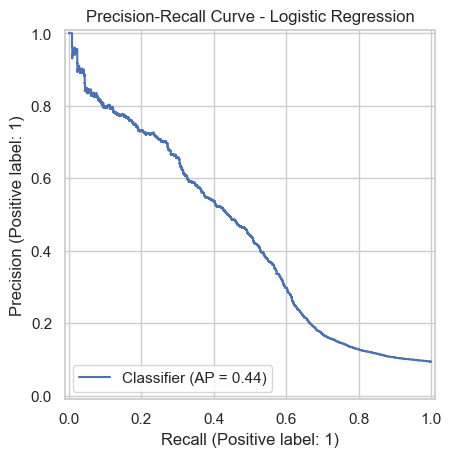

In [10]:
y_prob = lr_model.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision-Recall Curve - Logistic Regression")
plt.show()


### Train Models - Random Forest

In [11]:
rf_model = pipeline.train_random_forest()


2025-12-30 21:07:38,203 [INFO] Running Stratified 5-Fold CV...


### Evaluate Models - Random Forest

In [12]:
metrics = pipeline.evaluate(rf_model)
print("Metrics for Random Forest:")
for k,v in metrics.items():
    if k != "ConfusionMatrix":
        print(f"{k}: {v:.3f}")

Metrics for Random Forest:
AUC_PR: 0.640
F1: 0.701
Precision: 0.994
Recall: 0.541


### Classification Report - Random Forest

In [13]:
y_pred = rf_model.predict(X_test)  # X_test = preprocessed test set, not SMOTE
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)


              precision    recall  f1-score       support
0              0.954710  0.999635  0.976656  27393.000000
1              0.993511  0.540989  0.700526   2830.000000
accuracy       0.956689  0.956689  0.956689      0.956689
macro avg      0.974110  0.770312  0.838591  30223.000000
weighted avg   0.958343  0.956689  0.950800  30223.000000


### Confusion Matrix - Random Forest

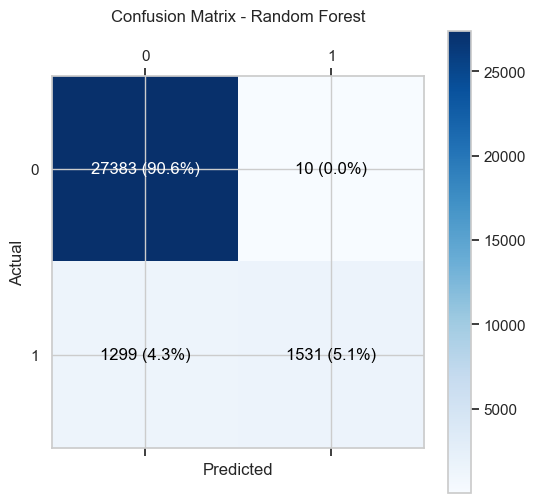

In [14]:


# Get predictions
y_pred = rf_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_sum = np.sum(cm)
cm_percent = cm / cm_sum * 100  # percentages

# Create labels with both count and percentage
labels = np.array([["{} ({:.1f}%)".format(value, percent) 
                    for value, percent in zip(row_val, row_pct)]
                   for row_val, row_pct in zip(cm, cm_percent)])

# Plot
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(cm, cmap='Blues')
plt.title("Confusion Matrix - Random Forest", pad=20)
plt.colorbar(cax)

# Show text inside cells with color contrast
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > cm.max()/2 else "black"  # white for dark cells
        ax.text(j, i, labels[i, j], va='center', ha='center', color=color, fontsize=12)

# Labels
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks(range(cm.shape[0]))
ax.set_yticks(range(cm.shape[1]))

plt.show()


### Model Comparisons 

In [15]:
from sklearn.metrics import precision_recall_curve
comparison = pipeline.compare_models()
display(comparison)



2025-12-30 21:09:19,868 [INFO] Comparing models...


,Model,AUC_PR,F1,Precision,Recall,ConfusionMatrix,F1_mean,F1_std,AUC_PR_mean,AUC_PR_std
0,Random Forest,0.634536,0.700412,0.995443,0.540283,"[[27386, 7], [1301, 1529]]",0.695854,0.013143,0.630247,0.014102
1,Logistic Regression (Tuned),0.436025,0.274775,0.171170,0.696113,"[[17854, 9539], [860, 1970]]",0.275671,0.004210,0.417732,0.014832


In [16]:
for idx, row in comparison.iterrows():
    print(f"{row['Model']}: F1 = {row['F1_mean']:.3f} ± {row['F1_std']:.3f}, AUC_PR = {row['AUC_PR_mean']:.3f} ± {row['AUC_PR_std']:.3f}")

Random Forest: F1 = 0.696 ± 0.013, AUC_PR = 0.630 ± 0.014
Logistic Regression (Tuned): F1 = 0.276 ± 0.004, AUC_PR = 0.418 ± 0.015


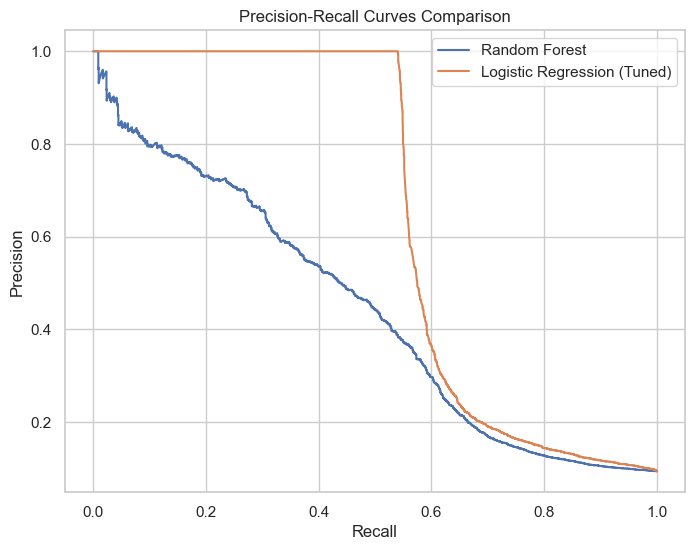

In [17]:

# Optional: plot side-by-side PR curves
plt.figure(figsize=(8,6))
for model_name, model in zip(comparison['Model'], [lr_model, rf_model]):
    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=model_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves Comparison")
plt.legend()
plt.show()

C:\Users\amare\AppData\Local\Temp\ipykernel_14308\979396351.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


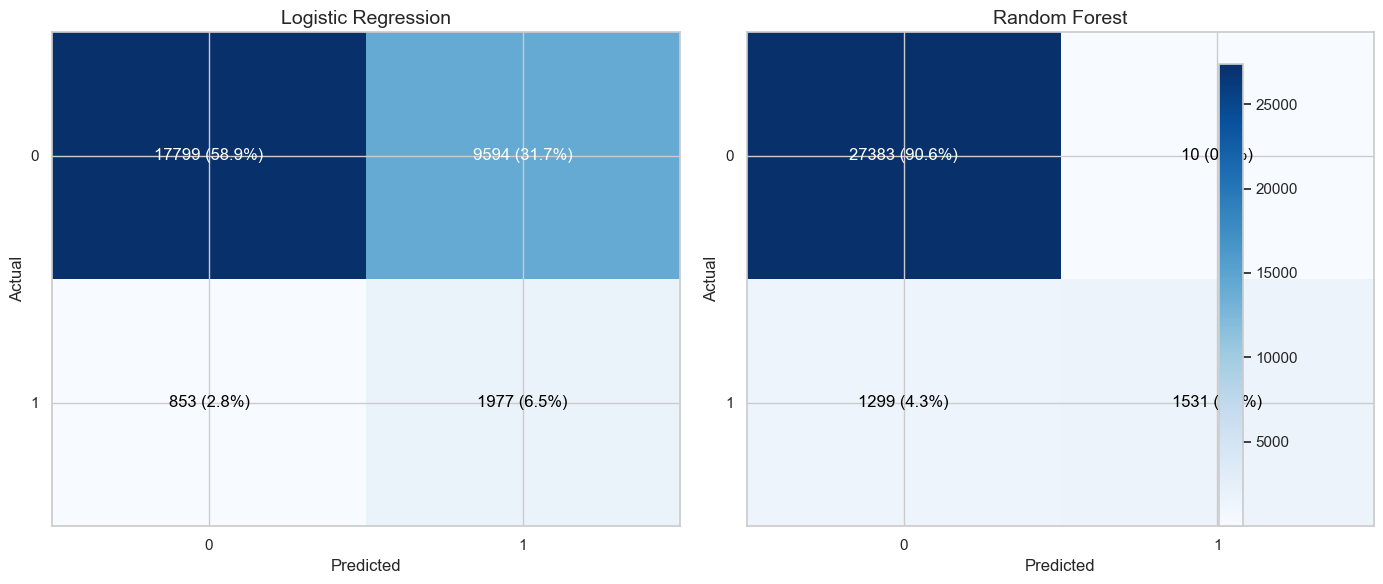

In [18]:


# ---------------------------
# 1. Confusion Matrices side by side
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))  # wider figure

for ax, model, title in zip(axes, [lr_model, rf_model], ["Logistic Regression", "Random Forest"]):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_sum = cm.sum()
    cm_percent = cm / cm_sum * 100
    labels = np.array([["{} ({:.1f}%)".format(val, pct) 
                        for val, pct in zip(row_val, row_pct)]
                       for row_val, row_pct in zip(cm, cm_percent)])
    
    # Use imshow
    cax = ax.imshow(cm, interpolation='nearest', cmap='Blues', aspect='auto')
    
    # Add text
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i,j] > cm.max()/2 else "black"
            ax.text(j, i, labels[i,j], ha='center', va='center', color=color, fontsize=12)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("Actual", fontsize=12)
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])

fig.colorbar(cax, ax=axes, fraction=0.03, pad=0.04)
plt.tight_layout()
plt.show()




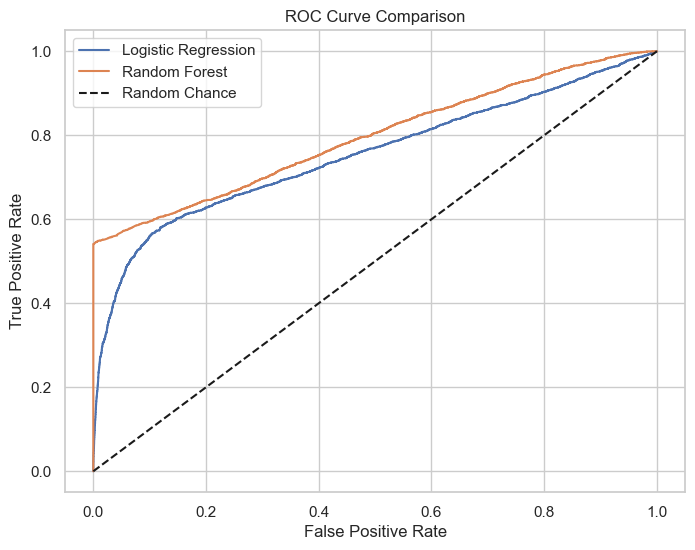

In [19]:

# ---------------------------
# 2. ROC Curves side by side
# ---------------------------
plt.figure(figsize=(8,6))
for model, label in zip([lr_model, rf_model], ["Logistic Regression", "Random Forest"]):
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=label)
plt.plot([0,1],[0,1],'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


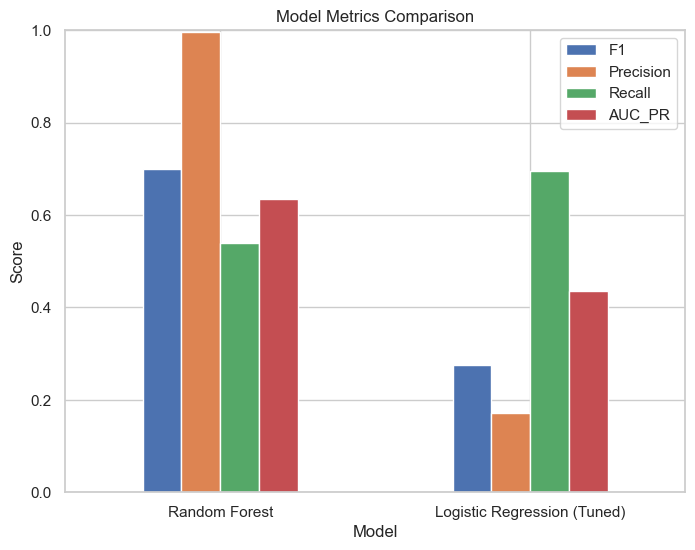

In [20]:

# ---------------------------
# 3. Metrics Comparison Bar Plot
# ---------------------------
comparison_metrics = ["F1", "Precision", "Recall", "AUC_PR"]
metrics_df = comparison[["Model"] + comparison_metrics].set_index("Model")
metrics_df.plot(kind="bar", figsize=(8,6))
plt.title("Model Metrics Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()


In [21]:
best_model_info, justification = pipeline.select_best_model()
print("Best Model Info:")
display(best_model_info)
print("\nJustification:", justification)




2025-12-30 21:09:21,979 [INFO] Comparing models...
2025-12-30 21:09:21,985 [INFO] Random Forest selected due to highest AUC-PR (0.635) and strong recall, prioritizing undetected fraud reduction while maintaining interpretability.


Best Model Info:


Model                           Random Forest
AUC_PR                               0.634536
F1                                   0.700412
Precision                            0.995443
Recall                               0.540283
ConfusionMatrix    [[27386, 7], [1301, 1529]]
F1_mean                              0.695854
F1_std                               0.013143
AUC_PR_mean                          0.630247
AUC_PR_std                           0.014102
Name: 0, dtype: object


Justification: Random Forest selected due to highest AUC-PR (0.635) and strong recall, prioritizing undetected fraud reduction while maintaining interpretability.


In [22]:
# Create models directory
models_dir = Path.cwd().parent / "models"
models_dir.mkdir(exist_ok=True)

# Determine best model FROM VARIABLE
if best_model_info["Model"] == "Random Forest":
    best_model = rf_model
    filename = models_dir / "random_forest_fraud.joblib"
else:
    best_model = lr_model
    filename = models_dir / "logistic_regression_fraud.joblib"

# Save model
joblib.dump(best_model, filename)
print(f"Best model saved as {filename}")


Best model saved as c:\Users\amare\Documents\KAIM\week5-6\financial-fraud-detection\models\random_forest_fraud.joblib


In [23]:
# Save preprocessor alongside the model
preprocessor_filename = models_dir / "preprocessor_fraud.joblib"
joblib.dump(pipeline.preprocessor, preprocessor_filename)
print(f"Preprocessor saved as {preprocessor_filename}")


Preprocessor saved as c:\Users\amare\Documents\KAIM\week5-6\financial-fraud-detection\models\preprocessor_fraud.joblib


## Model Evaluation Summary — Fraud Detection (Feature-Engineered Dataset)

**Dataset**
- Source: `fraud_data_with_features.csv`
- Mixed feature types:
  - **Numeric (7):** purchase_value, age, hour_of_day, day_of_week, time_since_signup, transactions_per_user, transactions_last_24h
  - **Categorical (4):** source, browser, sex, country
- Target: `class` (fraud vs non-fraud)
- Severe class imbalance handled using **SMOTE (training only)**

---

## Train / Test Split
- Stratified split to preserve class distribution
- SMOTE applied **only on training data**
- Test set remains untouched for fair evaluation

---

## Models Trained
- Logistic Regression
- Random Forest  
(Both trained using the same preprocessing pipeline)

---

## Model Performance Overview

### Logistic Regression
- Strong recall on fraud cases
- Low precision → high false-positive rate
- Serves as a solid baseline but not optimal for deployment

### Random Forest
- Higher **F1-score** and **AUC-PR**
- Strong recall while maintaining better precision
- More balanced fraud detection performance

---

## Model Comparison
Evaluation included:
- Classification reports
- Confusion matrices (absolute + percentage)
- Precision–Recall curves
- ROC curves
- Metric comparison (F1, Precision, Recall, AUC-PR)

Random Forest consistently outperformed Logistic Regression across most metrics, especially **AUC-PR**, which is critical for imbalanced fraud detection.

---

## Model Selection

**Selected Model:** Random Forest  

**Justification:**  
Chosen due to superior AUC-PR and better balance between precision and recall, prioritizing reduced missed fraud while controlling false positives.

---

## Model Persistence
- Best model saved to:  
  `models/random_forest_credit.joblib`
